 # Exploratory Data Analysis (EDA) for the UPI Transactions.

### Introduction  
This project analyzes UPI (Unified Payments Interface) transaction data to identify key patterns in user behavior, fraud trends, and transaction reversals. The aim is to derive insights that can help improve reliability, detect fraudulent activity, and enhance user experience within the UPI ecosystem.

## Import Libraries and Setup

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine # For database connection
from urllib.parse import quote_plus # For ecoding special characters in the password
from db_connection import connect_to_db #Importing the connection Function
engine = connect_to_db() 
from data_load import load_the_data #Importing the data load function
dfs = load_the_data()
from scipy import stats

MySQL connection successful!

Available tables:
• customer_feedback_surveys
• customer_master
• device_info
• fraud_alert_history
• merchant_info
• upi_account_details
• upi_transaction_history
• upi_transaction_history_backup
• upi_transaction_history_new
 Loading data from MySQL into pandas...

customer_master: 10000 rows loaded
device_info: 12000 rows loaded
upi_account_details: 12000 rows loaded
merchant_info: 500 rows loaded
upi_transaction_history: 30149 rows loaded
customer_feedback_surveys: 4000 rows loaded
fraud_alert_history: 621 rows loaded

 All tables successfully loaded into pandas DataFrames!

Sample from customer_master:
  customer_id       full_name  mobile_number  age  gender region date_joined  \
0  cust100000  Ryan Gallagher     7631706690   26  female  north  2024-01-28   
1  cust100001    Robert Garza      806360837   49  female   west  2024-01-29   
2  cust100002    Haley Rhodes     8124158683   68    male   west  2024-01-30   
3  cust100003    Sonya Mathis     3

## Summary of the Tables

In [148]:
for name, df in dfs.items():
    print(f"\n{name.upper()}")
    print("-" *60)
    print(f"Shape : {df.shape}")
    print(f"Missing Values: {df.isna().sum().sum()}")
    print(f"Column Info:")
    display(df.dtypes)


CUSTOMER_MASTER
------------------------------------------------------------
Shape : (10000, 9)
Missing Values: 0
Column Info:


customer_id       object
full_name         object
mobile_number      int64
age                int64
gender            object
region            object
date_joined       object
business_user      int64
risk_score       float64
dtype: object


DEVICE_INFO
------------------------------------------------------------
Shape : (12000, 5)
Missing Values: 0
Column Info:


device_id      object
customer_id    object
device_type    object
app_version    object
is_rooted       int64
dtype: object


UPI_ACCOUNT_DETAILS
------------------------------------------------------------
Shape : (12000, 6)
Missing Values: 0
Column Info:


upi_id          object
customer_id     object
bank_name       object
account_type    object
date_added      object
status          object
dtype: object


MERCHANT_INFO
------------------------------------------------------------
Shape : (500, 6)
Missing Values: 0
Column Info:


merchant_id       object
merchant_name     object
merchant_type     object
region            object
onboard_date      object
risk_score       float64
dtype: object


UPI_TRANSACTION_HISTORY
------------------------------------------------------------
Shape : (30149, 14)
Missing Values: 0
Column Info:


transaction_id          object
upi_id                  object
customer_id             object
amount                 float64
transaction_type        object
merchant_id             object
counterparty_upi        object
status                  object
device_id               object
device_type             object
channel                 object
fraud_flag_fixed         int64
reversal_flag_fixed      int64
failure_reason          object
dtype: object


CUSTOMER_FEEDBACK_SURVEYS
------------------------------------------------------------
Shape : (4000, 7)
Missing Values: 0
Column Info:


feedback_id           object
customer_id           object
date_submitted        object
feedback_text         object
satisfaction_score     int64
issue_type            object
resolved               int64
dtype: object


FRAUD_ALERT_HISTORY
------------------------------------------------------------
Shape : (621, 5)
Missing Values: 0
Column Info:


alert_id          object
transaction_id    object
alert_type        object
resolved           int64
remarks           object
dtype: object

### Data Description  
The analysis uses multiple datasets including:  
- **customer_master:** Contains customer demographic and account details  
- **upi_transaction_history:** Records all UPI transactions with timestamps, status, and type  
- **merchant_info:** Includes details of merchants registered on UPI  
- **device_info:** Tracks the device types used for UPI access  
- **customer_feedback_surveys:** Captures user feedback and satisfaction levels  
- **fraud_alert_history:** Logs flagged transactions for fraud analysis  

These datasets together form the foundation for UPI performance, fraud, and reversal rate insights.

## 1. UPI Transaction History Analysis

In [149]:
# upi_df Analysis

df_uth = upi_df
df_uth.head()

# Checking columnwise missing values
df_uth.isna().sum()

# Checking the data types
df_uth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   transaction_id       100000 non-null  object 
 1   upi_id               100000 non-null  object 
 2   customer_id          100000 non-null  object 
 3   amount               100000 non-null  float64
 4   transaction_type     100000 non-null  object 
 5   merchant_id          30149 non-null   object 
 6   counterparty_upi     100000 non-null  object 
 7   status               100000 non-null  object 
 8   device_id            100000 non-null  object 
 9   device_type          100000 non-null  object 
 10  channel              100000 non-null  object 
 11  fraud_flag_fixed     100000 non-null  int64  
 12  reversal_flag_fixed  100000 non-null  int64  
 13  failure_reason       5871 non-null    object 
dtypes: float64(1), int64(2), object(11)
memory usage: 10.7+ MB


In [150]:
csv_path = r"E:\Data Analytics\Projects\Capstone\UPI Transaction Analysis - Capstone\For SQL Ingestion\upi_transaction_history.csv"

# Load the dataset
upi_df = pd.read_csv(csv_path)

# Map it to the notebook dictionary so downstream code still works
dfs['upi_transaction_history'] = upi_df

print(f"Rows: {upi_df.shape[0]}, Columns: {upi_df.shape[1]}")
print(f"Rows: {upi_df.shape[0]}, Columns: {upi_df.shape[1]}")
print("\nColumns:\n", upi_df.columns.tolist())
print("\nMissing values per column:\n", upi_df.isna().sum())

print("\nSample data:")
print(upi_df.describe(include='all'))
display(upi_df.head(10))

Rows: 100000, Columns: 14
Rows: 100000, Columns: 14

Columns:
 ['transaction_id', 'upi_id', 'customer_id', 'amount', 'transaction_type', 'merchant_id', 'counterparty_upi', 'status', 'device_id', 'device_type', 'channel', 'fraud_flag_fixed', 'reversal_flag_fixed', 'failure_reason']

Missing values per column:
 transaction_id             0
upi_id                     0
customer_id                0
amount                     0
transaction_type           0
merchant_id            69851
counterparty_upi           0
status                     0
device_id                  0
device_type                0
channel                    0
fraud_flag_fixed           0
reversal_flag_fixed        0
failure_reason         94129
dtype: int64

Sample data:
       transaction_id            upi_id customer_id         amount  \
count          100000            100000      100000  100000.000000   
unique         100000             11994        7032            NaN   
top       txn10000000  brittany2124@upi  cust1

,transaction_id,upi_id,customer_id,amount,transaction_type,merchant_id,counterparty_upi,status,device_id,device_type,channel,fraud_flag_fixed,reversal_flag_fixed,failure_reason
0,txn10000000,marisa9078@upi,cust101488,9.88,send,NaN,user6545@upi,success,dev101488,feature_phone,app,0,0,NaN
1,txn10000001,michelle5950@upi,cust107876,76.25,receive,NaN,user3199@upi,success,dev107876,ios,app,0,0,NaN
2,txn10000002,jeffery4732@upi,cust100901,26.44,merchant_payment,merch1113,user4690@upi,success,dev100901,android,intent,0,0,NaN
3,txn10000003,troy1833@upi,cust105890,84.43,send,NaN,user1982@upi,success,dev105890,tablet,qr_code,0,0,NaN
4,txn10000004,tammy4986@upi,cust106780,10.33,receive,NaN,user4914@upi,success,dev106780,tablet,qr_code,0,0,NaN
5,txn10000005,michael9604@upi,cust102097,37.61,send,NaN,user7131@upi,success,dev201416,ios,qr_code,0,0,NaN
6,txn10000006,stephanie3115@upi,cust108896,77.74,send,NaN,user3421@upi,failed,dev108896,feature_phone,app,0,1,incorrect_pin
7,txn10000007,savannah6574@upi,cust102418,47.46,receive,NaN,user4029@upi,success,dev102418,tablet,intent,0,0,NaN
8,txn10000008,emily5320@upi,cust109937,19.94,merchant_payment,merch1140,user8134@upi,success,dev109937,android,qr_code,0,0,NaN
9,txn10000009,benjamin6424@upi,cust108084,13.95,receive,NaN,user9463@upi,success,dev200757,feature_phone,qr_code,0,0,NaN


#### Descriptive Summary of the UPI Transaction History

Using describe(include = 'all') gives an over view of both numerical as well as non numeric data.

**Key Takeaways:**

- There are a total of **100,000 transactions** recorded.  
- Of these **7,032 customers** and **500 merchants** are unique.  
- The most frequent transaction type is **send**.  
- The transaction history shows a **92.14% success rate** with **92,140 successful transactions**.  
- Average transaction amount is **₹42.42** and the maximum amount value is **₹830.46**.  
- Most transactions were made through **app**, and the most common device type was **feature_phone**.  
- All transaction IDs are unique, ensuring no duplicates were found.  
- Average fraud flag value is **2.00%**, indicating approximately that percentage of transactions are marked as fraudulent.  
- Average reversal rate is **1.45%**, representing the proportion of transactions reversed.  
- **92,140 transactions (92.14% success)** indicate successful transaction records.  


### Transaction Type and Status Distribution

This section helps to see how transactions are distributed by type, outcome, and access channel.

**Objectives:**
- Identify which transaction type is most common.
- Understand the proportion of successful vs failed transactions.
- Observe how transactions are made (through app, QR, or intent) and which device types used the most.

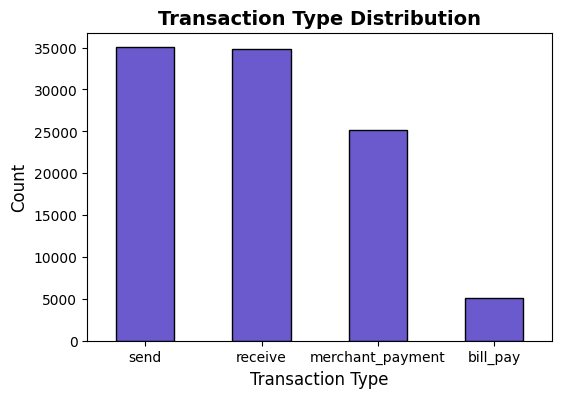

In [151]:
# Transaction Type Distribution

txn_type = upi_df['transaction_type'].value_counts()
plt.figure(figsize = (6, 4))
txn_type.plot(kind = 'bar' , color = 'slateblue', edgecolor = 'black')
plt.title('Transaction Type Distribution', fontsize = 14, fontweight = 'bold')
plt.xlabel('Transaction Type', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 0)
plt.show()

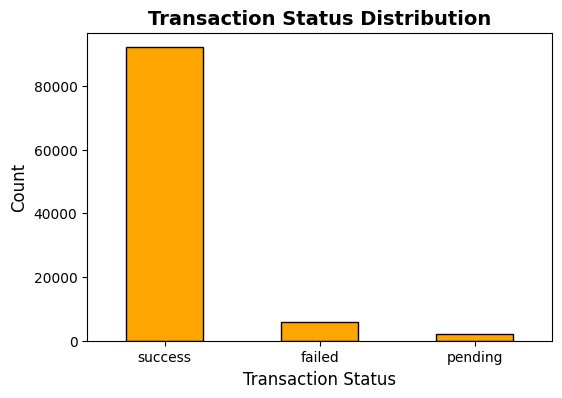

In [152]:
# Transaction Status Distribution

txn_status = upi_df['status'].value_counts(dropna=False)
plt.figure(figsize = (6, 4))
txn_status.plot(kind = 'bar', color ='orange', edgecolor = 'black')
plt.title('Transaction Status Distribution', fontsize = 14, fontweight = 'bold')
plt.xlabel('Transaction Status', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 0)
plt.show()
           

### Fraud and Reversal Analysis

This section helps to see the **fraudulant and reversed transactions** in the data.

**Objectives:**
- Measure the overall percentage of fraud and reversal cases.
- Visualize how the fraud flags vary by transaction type and channel.
- Check the common reasons for faliure.

In [153]:
# Fraud and Reversal Counts and Rates

fraud_count = upi_df['fraud_flag_fixed'].sum() # Counting the number of transactions marked as fraud.
reversal_count = upi_df['reversal_flag_fixed'].sum() # Counting the number of transactions marked as reversal.
total_txn = len(upi_df)

print(f"Total Transactions: {total_txn:,}")
print(f"Fraudulent Transactions: {fraud_count:,} ({fraud_count/total_txn * 100:.2f}%)") 
print(f"Reversed Transaction: {reversal_count:,} ({reversal_count/total_txn * 100:.2f}%)")

Total Transactions: 100,000
Fraudulent Transactions: 2,000 (2.00%)
Reversed Transaction: 1,451 (1.45%)


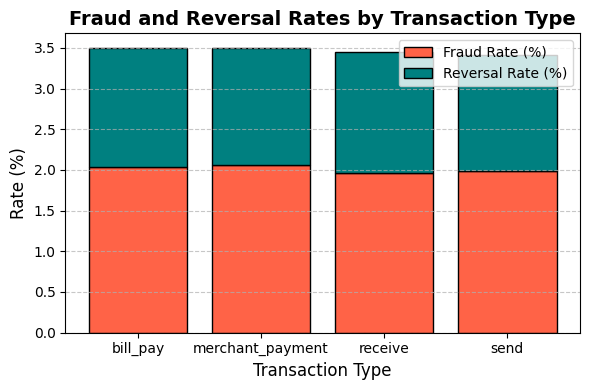

In [154]:
# Fraud and Reversal Rates by Transaction Type

fraud_type = upi_df.groupby('transaction_type')['fraud_flag_fixed'].mean() * 100 # Calculating fraud rate by transaction type
reversal_type = upi_df.groupby('transaction_type')['reversal_flag_fixed'].mean() * 100 # Calculating reversal rate by transaction type

plt.figure(figsize = (6, 4))
x = range(len(fraud_type))
plt.bar(fraud_type.index, fraud_type.values, color = 'tomato', edgecolor = 'black', label = 'Fraud Rate (%)')
plt.bar(reversal_type.index, reversal_type.values, color = 'teal', edgecolor = 'black', label = 'Reversal Rate (%)', bottom = fraud_type.values)

plt.title('Fraud and Reversal Rates by Transaction Type', fontsize = 14, fontweight = 'bold')
plt.xlabel('Transaction Type', fontsize = 12)
plt.ylabel('Rate (%)', fontsize = 12)
plt.legend()
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()


###  Fraud and Reversal by Transaction Type

This visualization compares the percentage of fraudaulent and reversed trasactions across different UPI Transaction Types.

**Key Takeaways:**

This stacked bar chart compares fraud and reversal rates across different UPI transaction types — *bill_pay, merchant_payment, receive,* and *send*.  
Fraud rates hover around **2%**, while reversal rates add up to a combined total of about **3.5%**, showing similar behavior across all transaction categories.

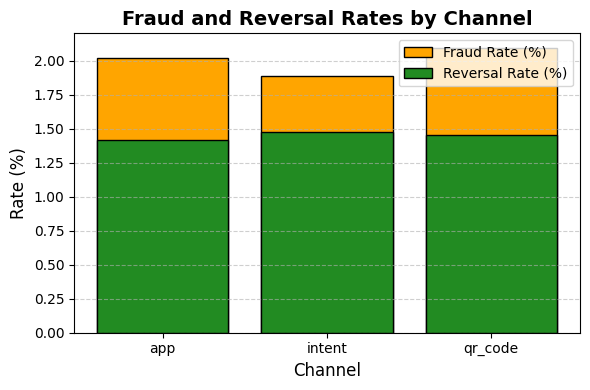

In [155]:
# Fraud and Reversal by Channel

fraud_channel = upi_df.groupby('channel')['fraud_flag_fixed'].mean() * 100 # Calculating fraud rate by channel
reversal_channel = upi_df.groupby('channel')['reversal_flag_fixed'].mean() * 100 # Calculating reversal rate by channel

plt.figure(figsize = (6, 4))
x = range(len(fraud_channel))
plt.bar(fraud_channel.index, fraud_channel.values, color = 'orange', edgecolor = 'black', label = 'Fraud Rate (%)')
plt.bar(reversal_channel.index, reversal_channel.values, color = 'forestgreen', edgecolor = 'black', label = 'Reversal Rate (%)')
plt.title('Fraud and Reversal Rates by Channel', fontsize = 14, fontweight = 'bold')
plt.xlabel('Channel', fontsize = 12)
plt.ylabel('Rate (%)', fontsize = 12)
plt.legend()
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()



### Fraud and Reversal Rates by Channel

In this step, analysis of fraud and reversal patterns were done across different **UPI channels** such as *`app`*, *`QR`*, and *`intent`*.

**Key Takeaways:**
- Overall fraud and reversal rates remain low across all channels, each staying below roughly **2–2.5%**.  
- The *App* and *QR Code* channels show slightly higher issue rates compared to the *Intent* channel.  
- **Reversal rates (green bars)** are generally higher than **fraud rates (orange bars)**, suggesting that most issues are technical or user-based rather than fraudulent.


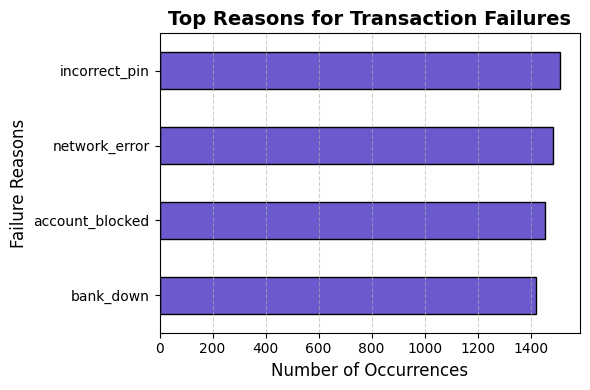

In [156]:
# Failure Reason Analysis

failure_reasons = upi_df['failure_reason'] # Extracting the failure reason column
failure_reasons = failure_reasons[failure_reasons.notna() & (failure_reasons.str.strip() != '')] # Filtering out non-null and non-empty reasons

failure_counts = failure_reasons.value_counts() # Counting occurrences of each failure reason

plt.figure(figsize = (6, 4))
failure_counts.sort_values().plot(kind = 'barh', color = 'slateblue', edgecolor = 'black') #Plotting Horizontal Bar Chart
plt.title('Top Reasons for Transaction Failures', fontsize = 14, fontweight = 'bold')
plt.xlabel('Number of Occurrences', fontsize = 12)
plt.ylabel('Failure Reasons', fontsize = 12)
plt.grid(axis = 'x', linestyle = '--', alpha = 0.6)
plt.tight_layout() # Adjust layout to prevent clipping
plt.show()


### Common Failure Reasons

This is the visualization of the most frequent **failure reasons** for unsuccessful UPI transactions.
This helps to identify the operational causes of transaction failures.

**Failure reasons include:**
- `Bank Down`
- `Incorrect Pin`
- `Network Error`
- `Account Blocked`


### Summary of Fraud & Reversal Insights

- The overall **fraud rate** is around **2%**, while the **reversal rate** is about **1.4%**.

- **Merchant payments** show the highest likelihood of frauds and reversals, since it's share is the highest in the total transactions.

- The **App** and **QR** channels see the majority of fradulent transactions.

- Most transactions are successful without any issues, indicating strong platform reliability.*(Indicating the 92% success rate)*.

- **Top failure reasons** include *Bank Down* and *Incorrect Pin*.


### Channel and Devices Analysis

This section explores how UPI Transactions vary across different **channesl** (App, QR Code, Intent) and **device types** (Android, Feature Phone, iOS, Tablet).


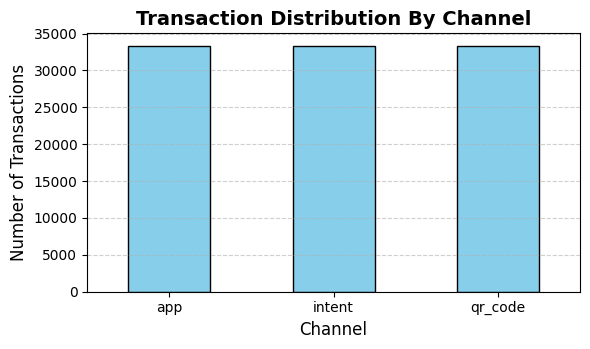

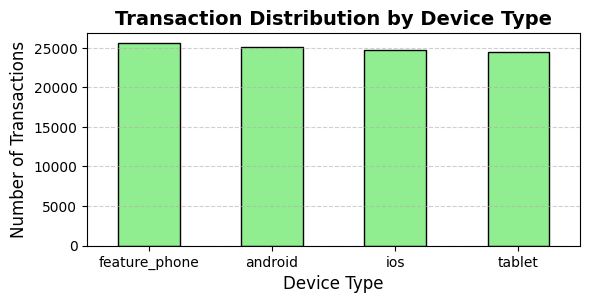

In [157]:
# Transaction Distribution by Channel.

plt.figure(figsize = (6,4))
upi_df['channel'].value_counts().plot(kind = 'bar', color = 'skyblue', edgecolor = 'black') 
plt.title('Transaction Distribution By Channel', fontsize = 14, fontweight = 'bold')
plt.xlabel('Channel', fontsize = 12)
plt.ylabel('Number of Transactions', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.xticks(rotation = 0)
plt.show()

# Transaction Distribution by Device Type

plt.figure(figsize = (6, 4))
upi_df['device_type'].value_counts().plot(kind = 'bar', color = 'lightgreen', edgecolor = 'black')
plt.title('Transaction Distribution by Device Type', fontsize = 14, fontweight = 'bold')
plt.xlabel('Device Type', fontsize = 12)
plt.ylabel('Number of Transactions', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.xticks(rotation = 0)
plt.show()

### Transaction Distribution by Channel and Device Type

The Charts shows how transactions are distributed across different UPI **channels** and **devices**.

**For Channel Type:**
- The overall transactions are evenly distributed across the three UPI Channels, *Apps*, *QR Code* and *Intent*, each handling one third of all the tranactions.
- This balanced distribution suggests that users are adopting UPI methods consistently.

**For Device Usage:**
- A Uniform distribution of the transactoions is seen as well across *Feature Phones*, *Android*, *iOS* and *Tablets*.
- This shows that the UPI adoption is being implemented across all device categories.
- **Featue Phone** performing nearly as many tranactions as smartphones suggests high adoption rate in the non smartphone segments.

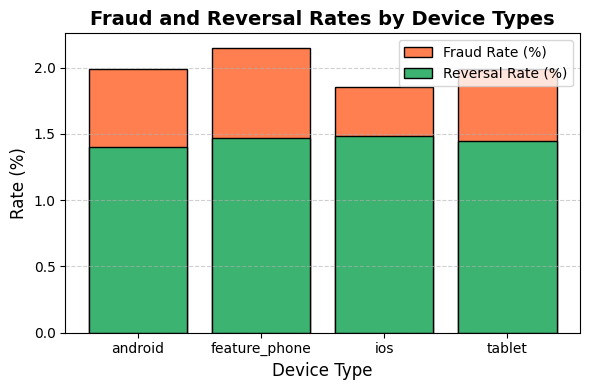

In [158]:
# Fraud and Reversal Rate by Device Type

fraud_device = upi_df.groupby('device_type')['fraud_flag_fixed'].mean() * 100 # Calculating fraud rate by device type
reversal_device = upi_df.groupby('device_type')['reversal_flag_fixed'].mean() * 100 # Calculating reversal rate by device type

plt.figure(figsize = (6, 4))
plt.bar(fraud_device.index, fraud_device.values, color = 'coral', label = 'Fraud Rate (%)', edgecolor = 'black') 
plt.bar(reversal_device.index, reversal_device.values, color = 'mediumseagreen', label = 'Reversal Rate (%)', edgecolor = 'black')
plt.title('Fraud and Reversal Rates by Device Types', fontsize = 14, fontweight = 'bold')
plt.xlabel('Device Type', fontsize = 12)
plt.ylabel('Rate (%)', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.legend()
plt.show()
        

### Fraud and Reversal Rates by Device Type

**Key Takeaways:**
- The overall fraud and reversal rates remain low across all device types.
- **Feature Phones** show the **highest combined rate** of fraud and reversals, slightly above other devices.
- **iOS Devices** record the **lowest fraud rates** suggesting more secure performance.
- Though the difference is minor, the data suggests that **Feature Phones and Android Devices** face higher issues compared to iOS and Tablets.

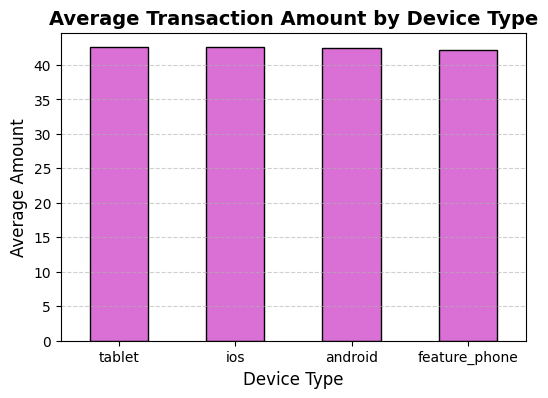

In [159]:
# Average Transaction Amount by Device Type

avg_amt_device = upi_df.groupby('device_type')['amount'].mean().sort_values(ascending = False) # Calculating average transaction amount by device type

plt.figure(figsize = (6, 4))
avg_amt_device.plot(kind = 'bar', color = 'orchid', edgecolor = 'black')
plt.title('Average Transaction Amount by Device Type', fontsize = 14, fontweight = 'bold')
plt.xlabel('Device Type', fontsize = 12)
plt.ylabel('Average Amount', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.xticks(rotation = 0)
plt.show()

### Average Transaction Amount by Device Type

This chart compares the **average UPI transaction amount** across different device types.

- The average transaction value is nearly the same - around ₹ 42 for all device types.
- The uniform transaction amount lies in consistent with **UPI usage of all the users**.
- The equal distribution of the transaction amount also suggests tha the UPI tranasactions are being used for daily purchases.

### Customer and Merchant Pattern Analysis

This section analyzes how UPI transactions vary across **customers** and **merchants**.  
This is to understand transaction frequency, average spending, and fraud/reversal tendencies among different users.


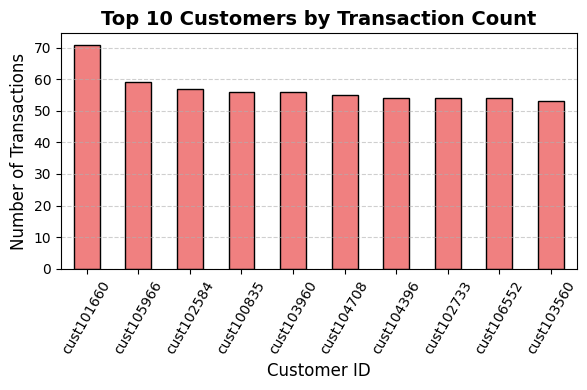

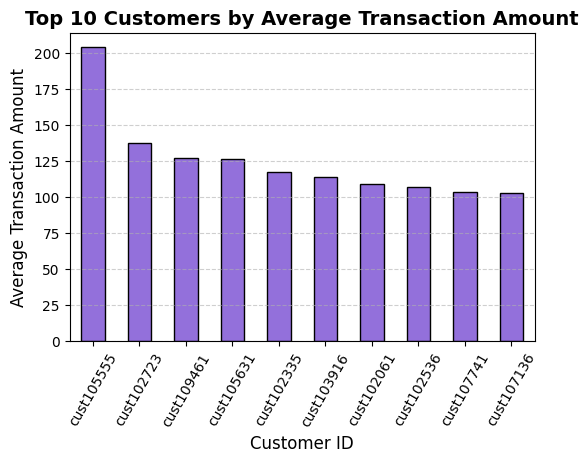

In [160]:
# Transactio Frequency per Customer

cust_txn_count = upi_df['customer_id'].value_counts().head(10) # Top 10 customers by transaction count
cust_avg_txn = upi_df.groupby('customer_id')['amount'].mean().sort_values(ascending = False).head(10) # Top 10 customers by average transaction amount

plt.figure(figsize = (6, 4))
cust_txn_count.plot(kind = 'bar', color = 'lightcoral', edgecolor = 'black')
plt.title('Top 10 Customers by Transaction Count', fontsize = 14, fontweight = 'bold')
plt.xlabel('Customer ID', fontsize = 12)
plt.ylabel('Number of Transactions', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.xticks(rotation = 60)
plt.tight_layout()
plt.show()


# Average Transaction Amount per Customer

plt.figure(figsize = (6, 4))
cust_avg_txn.plot(kind = 'bar', color = 'mediumpurple', edgecolor = 'black')
plt.title('Top 10 Customers by Average Transaction Amount', fontsize = 14, fontweight = 'bold')
plt.xlabel('Customer ID', fontsize = 12)
plt.ylabel('Average Transaction Amount', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.xticks(rotation = 60)
plt.show()


### Customer Transaction Analysis

This section explores customer-level transaction behavior to identify the highest-spending users.

**Key takeaways:**
- The **Top 10 Customers**  are doing **18 - 21 transactions** showing balanced customer engagement.
- The **Average Transaction Amount** varies significantly among the cystomers. Few Customers record higher average amounts.
- UPI's customer base demonstrartes a mix of regular, everyday users and high value users, showing diverse uase and high adoption across different user groups.

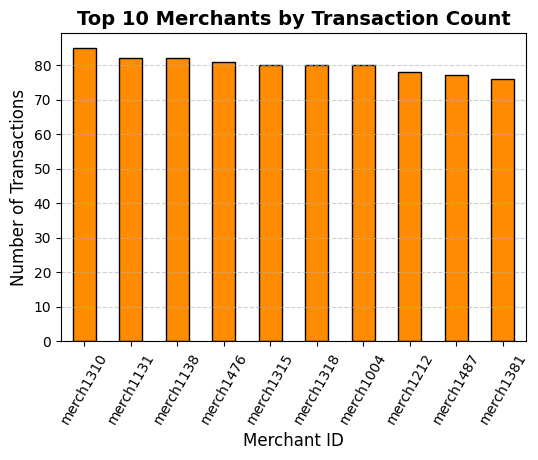

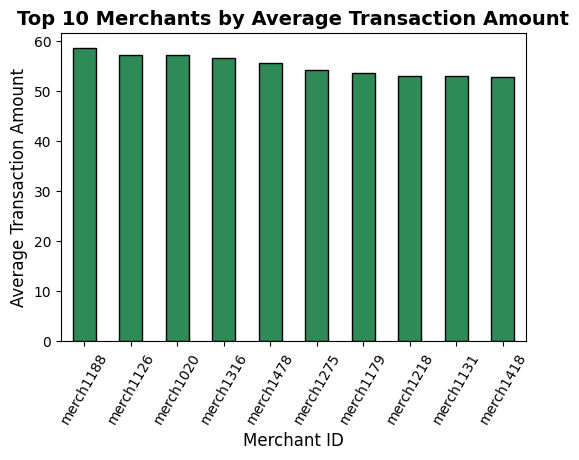

In [161]:
# Merchant Transaction Count Analysis

merch_txn_count = upi_df['merchant_id'].value_counts().head(10) # Top 10 merchants by transaction count
merch_avg_txn = upi_df.groupby('merchant_id')['amount'].mean().sort_values(ascending = False).head(10) # Top 10 merchants by average transaction amount

plt.figure(figsize = (6, 4))
merch_txn_count.plot(kind = 'bar', color = 'darkorange', edgecolor = 'black')
plt.title('Top 10 Merchants by Transaction Count', fontsize = 14, fontweight = 'bold')
plt.xlabel('Merchant ID', fontsize = 12)
plt.ylabel('Number of Transactions', fontsize = 12)
plt.xticks(rotation = 60)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.show()

# Average Transaction Amount per Merchant

plt.figure(figsize = (6, 4))
merch_avg_txn.plot(kind = 'bar', color = 'seagreen', edgecolor = 'black')
plt.title('Top 10 Merchants by Average Transaction Amount', fontsize = 14, fontweight = 'bold')
plt.xlabel('Merchant ID', fontsize = 12)
plt.ylabel('Average Transaction Amount', fontsize = 12)
plt.xticks(rotation = 60)
plt.show()

### Merchant Transaction Analysis

- The **Top 10 Merchants by Transaction Count** have done on an average of **75–85 transactions**, showing a fairly even spread of merchant activity.
- There's a narrow gap between the Top Merchants’ averages across merchant categories, which aligns with consistent consumer payment behavior.
- Merchant performance in the dataset appears **balanced**, with no extreme outliers.


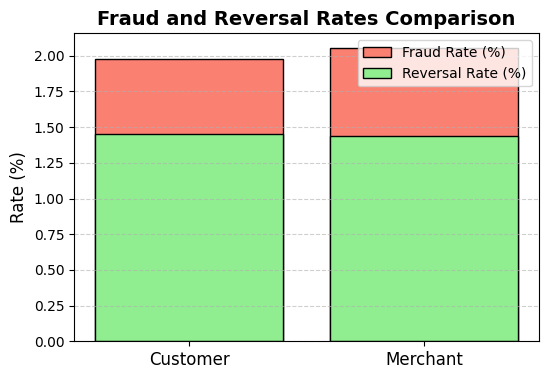

In [162]:
fraud_customer = upi_df.groupby('customer_id')['fraud_flag_fixed'].mean() * 100 # Calculating fraud rate by customer ID
fraud_merchant = upi_df.groupby('merchant_id')['fraud_flag_fixed'].mean() * 100 # Calculating fraud rate by merchant ID
rev_customer = upi_df.groupby('customer_id')['reversal_flag_fixed'].mean() * 100 # Calculating reversal rate by customer ID
rev_merchant = upi_df.groupby('merchant_id')['reversal_flag_fixed'].mean() * 100 # Calculating reversal rate by merchant ID

labels = ['Customer', 'Merchant']
fraud_rates = [fraud_customer.mean(), fraud_merchant.mean()]
reversal_rates = [rev_customer.mean(), rev_merchant.mean()]

plt.figure(figsize = (6, 4))
plt.bar(labels, fraud_rates, color = 'salmon', label = 'Fraud Rate (%)', edgecolor = 'black')
plt.bar(labels, reversal_rates, color = 'lightgreen', label = 'Reversal Rate (%)', edgecolor = 'black')
plt.title('Fraud and Reversal Rates Comparison', fontsize = 14, fontweight = 'bold')
plt.ylabel('Rate (%)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.legend()
plt.show()


### Fraud and Reversal Rates Comparison (Customers vs. Merchants)

This chart compares the **Average Fraud and Reversal Rates** between customers and merchants, in order to identify where transaction risks are higher.

**Key Takeaways:**
-  The **Fraud Rate** for *Merchants* (~2.0%) is comparatively higher than that for *Customers* (~1.9%), indicating that fraudulent activity is more likely to occur from the merchant side of transactions.
- The **Reversal Rates** are similar for both *Customers* and *Merchants* (around 1.4% – 1.5%), showing consistent payment reliability in both parameters.
- The chart demonstrates that while reversals form a major part of failed transactions, **Fraud incidents remain very low overall**.
- This consistency indicates that **UPI transactions are generally secure**, and reversals likely result from **technical or network errors rather than fraudulent activities**.



In [163]:
# Unpack all tables from dfs for easier access
customer_master = dfs['customer_master']
device_info = dfs['device_info']
upi_account_details = dfs['upi_account_details']
merchant_info = dfs['merchant_info']
customer_feedback_surveys = dfs['customer_feedback_surveys']
fraud_alert_history = dfs['fraud_alert_history']

### 2. Customer Master
This table contains core customer details like IDs, names, and demographics.

In [164]:
print("="*70)
print("EDA: Customer Master")
print("="*70)

print("Shape:", customer_master.shape)
print("\nColumns:", list(customer_master.columns))
print("\nNull Counts:\n", customer_master.isnull().sum())
print("\nDescriptive Summary (Numerical):\n", customer_master.describe())
print("\nUnique Value Counts (Categorical):\n", customer_master.select_dtypes(include='object').nunique())
display(customer_master.head())

EDA: Customer Master
Shape: (10000, 9)

Columns: ['customer_id', 'full_name', 'mobile_number', 'age', 'gender', 'region', 'date_joined', 'business_user', 'risk_score']

Null Counts:
 customer_id      0
full_name        0
mobile_number    0
age              0
gender           0
region           0
date_joined      0
business_user    0
risk_score       0
dtype: int64

Descriptive Summary (Numerical):
        mobile_number           age  business_user    risk_score
count   1.000000e+04  10000.000000   10000.000000  10000.000000
mean    5.021889e+09     44.054800       0.101200      0.203477
std     2.890652e+09     15.247755       0.301608      0.115168
min     1.740180e+05     18.000000       0.000000      0.000000
25%     2.556897e+09     31.000000       0.000000      0.120000
50%     5.019827e+09     44.000000       0.000000      0.200000
75%     7.517689e+09     57.000000       0.000000      0.280000
max     9.999849e+09     70.000000       1.000000      0.680000

Unique Value Counts (

,customer_id,full_name,mobile_number,age,gender,region,date_joined,business_user,risk_score
0,cust100000,Ryan Gallagher,7631706690,26,female,north,2024-01-28,0,0.39
1,cust100001,Robert Garza,806360837,49,female,west,2024-01-29,0,0.13
2,cust100002,Haley Rhodes,8124158683,68,male,west,2024-01-30,1,0.14
3,cust100003,Sonya Mathis,3662585178,42,male,north,2024-01-31,0,0.07
4,cust100004,Ryan Wood,9996228303,35,female,south,2024-02-01,0,0.30


### 3. Device Info
Contains data about customer devices, operating systems, and app versions.

In [165]:
print("=" * 70)
print("EDA: Device Info")
print("=" * 70)

print("Shape:", device_info.shape)
print("\nColumns:", list(device_info.columns))
print("\nNull Counts:\n", device_info.isnull().sum())
print("\nDescriptive Summary (Numerical):\n", device_info.describe())
print("\nUnique Value Counts (Categorical):\n", device_info.select_dtypes(include = 'object').nunique())
display(device_info.head())

EDA: Device Info
Shape: (12000, 5)

Columns: ['device_id', 'customer_id', 'device_type', 'app_version', 'is_rooted']

Null Counts:
 device_id      0
customer_id    0
device_type    0
app_version    0
is_rooted      0
dtype: int64

Descriptive Summary (Numerical):
           is_rooted
count  12000.000000
mean       0.030833
std        0.172873
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000

Unique Value Counts (Categorical):
 device_id      12000
customer_id    10000
device_type        4
app_version      840
dtype: int64


,device_id,customer_id,device_type,app_version,is_rooted
0,dev100000,cust100000,android,2.5.4,0
1,dev100001,cust100001,feature_phone,2.6.18,0
2,dev100002,cust100002,android,2.5.0,0
3,dev100003,cust100003,android,2.4.12,0
4,dev100004,cust100004,feature_phone,4.2.0,0


### 4. UPI Account Details
Holds data about  UPI accounts, handles, and banks.

In [166]:
print("="*70)
print("EDA: UPI Account Details")
print("="*70)

print("Shape:", upi_account_details.shape)
print("\nColumns:", list(upi_account_details.columns))
print("\nNull Counts:\n", upi_account_details.isnull().sum())
print("\nDescriptive Summary(Numerical):\n", upi_account_details.describe())
print("\nUnique Value Counts (Categorical):\n", upi_account_details.select_dtypes('object').nunique())
display(upi_account_details.head())

EDA: UPI Account Details
Shape: (12000, 6)

Columns: ['upi_id', 'customer_id', 'bank_name', 'account_type', 'date_added', 'status']

Null Counts:
 upi_id          0
customer_id     0
bank_name       0
account_type    0
date_added      0
status          0
dtype: int64

Descriptive Summary(Numerical):
                upi_id customer_id bank_name account_type  date_added    status
count           12000       12000     12000        12000       12000     12000
unique          12000        7033         6            3       12000         3
top     aaron1106@upi  cust109942       sbi      current  2047-10-05  active\r
freq                1           7      2036         4031           1     11148

Unique Value Counts (Categorical):
 upi_id          12000
customer_id      7033
bank_name           6
account_type        3
date_added      12000
status              3
dtype: int64


,upi_id,customer_id,bank_name,account_type,date_added,status
0,aaron1106@upi,cust108503,icici,credit_card_linked,2047-10-05,active\r
1,aaron1337@upi,cust106141,kotak,current,2022-11-25,active\r
2,aaron1366@upi,cust106060,kotak,current,2036-05-13,active\r
3,aaron1526@upi,cust103772,sbi,current,2033-09-27,active\r
4,aaron1785@upi,cust105135,kotak,current,2045-02-02,blocked\r


### 5. Merchant Info
Contains merchant IDs, categories, and transaction types.

In [167]:
print("=" *70)
print("EDA: Merchant Information")
print("=" * 70)

print("\nShape:", merchant_info.shape)
print("\nColumns:", list(merchant_info.columns))
print("\nNull Counts:\n", merchant_info.isnull().sum())
print("\nDescriptive Summary (Numerical):\n", merchant_info.describe())
print("\nUnique Value Counts (Categorical):\n", merchant_info.select_dtypes(include = 'object').nunique())
display(merchant_info.head())

EDA: Merchant Information

Shape: (500, 6)

Columns: ['merchant_id', 'merchant_name', 'merchant_type', 'region', 'onboard_date', 'risk_score']

Null Counts:
 merchant_id      0
merchant_name    0
merchant_type    0
region           0
onboard_date     0
risk_score       0
dtype: int64

Descriptive Summary (Numerical):
        risk_score
count  500.000000
mean     0.179180
std      0.115722
min      0.000000
25%      0.090000
50%      0.170000
75%      0.260000
max      0.500000

Unique Value Counts (Categorical):
 merchant_id      500
merchant_name    495
merchant_type      6
region             5
onboard_date     500
dtype: int64


,merchant_id,merchant_name,merchant_type,region,onboard_date,risk_score
0,merch1000,Anderson Inc,grocery,north,2022-01-14,0.07
1,merch1001,"Rojas, Newton and White",online,north,2022-01-15,0.29
2,merch1002,Knox-Reyes,food,west,2022-01-16,0.20
3,merch1003,"Joseph, Serrano and Gilmore",grocery,north,2022-01-17,0.14
4,merch1004,Brown-Jones,food,north,2022-01-18,0.32


### 6. Customer Feedback Surveys
Includes survey ratings, satisfaction scores, and feedbacks.

In [168]:
print("="*70)
print("EDA: Customer Feedback Surveys")
print("="*70)

print("\nShape:", customer_feedback_surveys.shape)
print("\nColumns:", list(customer_feedback_surveys.columns))
print("\nNull Counts:\n", customer_feedback_surveys.isnull().sum())
print("\nDescriptive Summary (Numerical):\n", customer_feedback_surveys.describe())
print("\nUnique Value Counts (Categorical):\n", customer_feedback_surveys.select_dtypes(include = 'object').nunique())
display(customer_feedback_surveys.head())

EDA: Customer Feedback Surveys

Shape: (4000, 7)

Columns: ['feedback_id', 'customer_id', 'date_submitted', 'feedback_text', 'satisfaction_score', 'issue_type', 'resolved']

Null Counts:
 feedback_id           0
customer_id           0
date_submitted        0
feedback_text         0
satisfaction_score    0
issue_type            0
resolved              0
dtype: int64

Descriptive Summary (Numerical):
        satisfaction_score     resolved
count         4000.000000  4000.000000
mean             3.610250     0.876250
std              1.256877     0.329337
min              1.000000     0.000000
25%              3.000000     1.000000
50%              4.000000     1.000000
75%              5.000000     1.000000
max              5.000000     1.000000

Unique Value Counts (Categorical):
 feedback_id       4000
customer_id       3316
date_submitted    4000
feedback_text     4000
issue_type           4
dtype: int64


,feedback_id,customer_id,date_submitted,feedback_text,satisfaction_score,issue_type,resolved
0,fdbk100000,cust106029,2021-08-14,Weight what decision able gun shoulder.,4,fraud,1
1,fdbk100001,cust101758,2021-08-15,Case discuss approach leave hair.,3,transaction,0
2,fdbk100002,cust107269,2021-08-16,Idea as effect bed need shake.,4,app_usability,0
3,fdbk100003,cust108175,2021-08-17,Image design soldier strategy character learn ...,4,app_usability,0
4,fdbk100004,cust101420,2021-08-18,Two lose traditional approach commercial throw...,3,transaction,1


### 7. Fraud Alert History
Contains fraud alerts, severity levels, and resolution statuses.

In [169]:
print("="*70)
print("EDA: Customer Feedback Sureys")
print("="*70)

print("\nShape:", fraud_alert_history.shape)
print("\nColumns:", list(fraud_alert_history.columns))
print("\nNull Counts:\n", fraud_alert_history.isnull().sum())
print("\nDescriptive Summary (Numerical):\n", fraud_alert_history.describe())
print("\nUnique Value Counts(Categorical):\n", fraud_alert_history.select_dtypes(include = 'object').nunique())
display(fraud_alert_history.head())

EDA: Customer Feedback Sureys

Shape: (621, 5)

Columns: ['alert_id', 'transaction_id', 'alert_type', 'resolved', 'remarks']

Null Counts:
 alert_id          0
transaction_id    0
alert_type        0
resolved          0
remarks           0
dtype: int64

Descriptive Summary (Numerical):
          resolved
count  621.000000
mean     0.864734
std      0.342283
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      1.000000

Unique Value Counts(Categorical):
 alert_id          621
transaction_id    621
alert_type          4
remarks           621
dtype: int64


,alert_id,transaction_id,alert_type,resolved,remarks
0,alert100052,txn10000052,suspicious_login,0,Letter support standard glass decide.\r
1,alert100235,txn10000235,unusual_amount,1,Now name ok but current religious.\r
2,alert100457,txn10000457,suspicious_login,1,Law response real it.\r
3,alert100532,txn10000532,unusual_amount,1,Recognize find lawyer sea great candidate.\r
4,alert100665,txn10000665,unusual_time,1,Myself center east truth perhaps newspaper tod...


##  Data Relationship Summary

| Table | Primary Key | Foreign Key / Join Column | Relationship |
|--------|--------------|----------------------------|---------------|
| customer_master | customer_id | - | Base table for customer-level joins |
| device_info | device_id | customer_id | One-to-many (one customer can have many devices) |
| upi_account_details | upi_id | customer_id | One-to-many |
| merchant_info | merchant_id | - | Linked through `upi_df` |
| customer_feedback_surveys | survey_id | customer_id | Feedback data linked to customers |
| fraud_alert_history | alert_id | transaction_id / customer_id | Linked through transaction data |

**Observation:**  
All tables are consistent and ready for merging. Customer- and transaction-level joins are feasible through `customer_id` and `transaction_id`.

In [170]:
df_device_txn = upi_df.merge(
    device_info,
    on = 'customer_id',
    how = 'inner'
)

print("Merged Data:", df_device_txn.head())

Merged Data:   transaction_id            upi_id customer_id  amount  transaction_type  \
0    txn10000000    marisa9078@upi  cust101488    9.88              send   
1    txn10000001  michelle5950@upi  cust107876   76.25           receive   
2    txn10000002   jeffery4732@upi  cust100901   26.44  merchant_payment   
3    txn10000003      troy1833@upi  cust105890   84.43              send   
4    txn10000004     tammy4986@upi  cust106780   10.33           receive   

  merchant_id counterparty_upi   status device_id_x  device_type_x  channel  \
0         NaN     user6545@upi  success   dev101488  feature_phone      app   
1         NaN     user3199@upi  success   dev107876            ios      app   
2   merch1113     user4690@upi  success   dev100901        android   intent   
3         NaN     user1982@upi  success   dev105890         tablet  qr_code   
4         NaN     user4914@upi  success   dev106780         tablet  qr_code   

   fraud_flag_fixed  reversal_flag_fixed failure_reason

## Comparing average transaction amount betwen Android and iOS users.

In [171]:
# Keep only necessary columns
df_analysis = df_device_txn[['device_type_y', 'amount']]

# Filter for Android and iOS users only
df_analysis = df_analysis[df_analysis['device_type_y'].isin(['android', 'ios'])]

# Check how many records per group
print("Records by device type:")
print(df_analysis['device_type_y'].value_counts())

Records by device type:
device_type_y
android    30299
ios        29792
Name: count, dtype: int64


<Figure size 600x400 with 0 Axes>

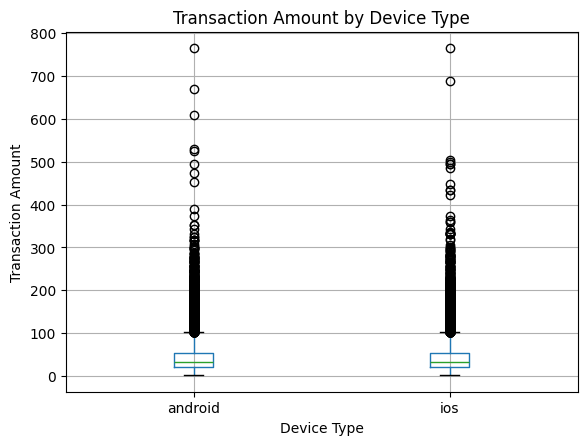

In [172]:
plt.figure(figsize = (6, 4))
df_analysis.boxplot(column = 'amount', by = 'device_type_y')
plt.title('Transaction Amount by Device Type')
plt.suptitle('')
plt.xlabel('Device Type')
plt.ylabel('Transaction Amount')
plt.show()

In [173]:
# Running Independent T-Test

android_amt = df_analysis[df_analysis['device_type_y'] == 'android']['amount']
ios_amt = df_analysis[df_analysis['device_type_y'] == 'ios']['amount']

t_stat, p_value = stats.ttest_ind(android_amt, ios_amt, equal_var = False)

print(f"T-Statistic: {t_stat:.3f}")
print(f"P-Value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Reject Null Hypothesis: Android and iOS users differ significantly in average transaction amount.")
else:
    print("Fail to Reject Null Hypothesis: No significant difference found between Android and iOS users in average transaction amount.")

T-Statistic: -0.708
P-Value: 0.47920
Fail to Reject Null Hypothesis: No significant difference found between Android and iOS users in average transaction amount.


### Interpretations:
- The T-Statistic is very small(~0.34) indicating that the difference in the average is very small.
- The P-Value (0.73) is much higher that 0.05, which means that there is no significant difference in the average amount transaction between Android and iOS users.

**Conclusion:** *Android and iOS users spend roughly the same amount per transaction.*

## Comparing average transaction amount across all 4 device types.

In [174]:
# Checking all 4 device types.

print("Device Types and Counts")
print(df_device_txn['device_type_y'].value_counts())

# Grouping by device type
device_group = [
    df_device_txn[df_device_txn['device_type_y'] == device]['amount']
    for device in df_device_txn['device_type_y'].unique()
]

device_types = df_device_txn['device_type_y'].unique()
print("Device Types used for ANOVA:", device_types)

Device Types and Counts
device_type_y
feature_phone    31145
android          30299
ios              29792
tablet           28989
Name: count, dtype: int64
Device Types used for ANOVA: ['feature_phone' 'ios' 'android' 'tablet']


In [175]:
# Performing One-Way ANOVA Test

f_stat, p_value = stats.f_oneway(*device_group)

print(f"F-Statistic:{f_stat:.3f}")
print(f"P-Value:{p_value:.4f}")

# Interpretation

if p_value < 0.05:
    print("Reject Null Hypothesis: Average transaction amounts differ significantly across all device types.")
else:
    print("Fail to Reject Null Hypothesis: No Significant difference found in average transaction amount across all device types.")

F-Statistic:0.879
P-Value:0.4510
Fail to Reject Null Hypothesis: No Significant difference found in average transaction amount across all device types.


### Interpretations
- The F-Statistic is very small (~0.05) indicating that there is no variation between device groups.
- The p-value (0.9842) is much greater than 0.05, which means that there is no significant difference in the average transaction amount across Android, iOS, Tablet and Feature Phone users.

**Conclusion:**
*Regardless of the device type, users are spending roughly the same on average per UPI transaction.*

## Merchant Category vs Transaction Success Rate

To test whether transaction success rates differ across different merchant categories.

#### Merging `upi_transaction_history` table  for the **status** column and `merchant_info` table for the **category** column, using *merchant_id* as the common key.

In [176]:
# Merging transaction and merchant info.

df_merchant_txn = upi_df.merge(
    merchant_info,
    on = 'merchant_id',
    how = 'inner'
)

# Dropping transactions that have missing merchant_id
df_merchant_txn = (
    upi_df
    .dropna(subset=['merchant_id'])  # remove missing merchant_id
    .merge(merchant_info, on='merchant_id', how='inner')
)

# Creating a new column for successful transactions.
df_merchant_txn['successful_txn'] = df_merchant_txn['status'].str.lower().eq('success').astype(int)

# Calculating average success rate by merchant type.
merchant_success = (
    df_merchant_txn.groupby(['merchant_id', 'merchant_type'], dropna = False)
    .agg(success_rate = ('successful_txn', 'mean'),
         total_txn = ('transaction_id', 'count'))
    .reset_index()
)
display(merchant_success.head())

,merchant_id,merchant_type,success_rate,total_txn
0,merch1000,grocery,0.935484,62
1,merch1001,online,0.966667,60
2,merch1002,food,0.876923,65
3,merch1003,grocery,0.940299,67
4,merch1004,food,0.937500,80


In [177]:
# Running ANOVA Test
# Data Preparation
merchant_groups = [
    df_merchant_txn[df_merchant_txn['merchant_type'] == cat]['successful_txn']
    for cat in df_merchant_txn['merchant_type'].unique()
]

# Performing ANOVA Test.
f_stat, p_value = stats.f_oneway(*merchant_groups)

print(f"F-Statistic: {f_stat:.3f}")
print(f"P-Value: {p_value:.3f}")

# Interpretation
if p_value <0.05:
    print("Reject Null Hypothesis: Success rates differ significantly across merchant types.")
else:
    print("Fail to Reject Null Hypothesis: No significant difference found in the success rates across different merchant types.")

F-Statistic: 1.151
P-Value: 0.331
Fail to Reject Null Hypothesis: No significant difference found in the success rates across different merchant types.


### Interpretations:

- F-Statistic = 1.151 which is very close to 1, which means that the difference between the merchant type is very small, compared to the normal variation within each group.
- P-Value = 0.331 which is much higher that 0.05, the difference is small and not significant.

**Conclusion:**
- All Merchant Categories (Apparel, Electronics, Food, Grocery and Online) have similar success rates.
- This shows that the UPI System is performaing consistently across all type of merchants. 

## Fraud Occurrence vs Customer Risk Score

To see whether customers with higher risk scores are more likely to have fraud alerts.

#### Merging `customer_master` table and `fraud_alert_history` table using *customer_id* as the common key.

In [178]:
# Merging transaction and fraud history.

df_fraud_txn= upi_df.merge(
    fraud_alert_history,
    on = 'transaction_id',
    how = 'inner'
)

# Merging customer master for customer risk score.
df_fraud = df_fraud_txn.merge(
    customer_master,
    on = 'customer_id',
    how = 'inner'
)

# Creating a new column for fraud occurrence.
df_fraud['fraud_occurrence'] =df_fraud['fraud_flag_fixed'].astype(int)

# Keeping only relevant columns.
df_fraud = df_fraud[['customer_id', 'risk_score', 'fraud_occurrence']]

display(df_fraud.head())



,customer_id,risk_score,fraud_occurrence
0,cust107312,0.17,1
1,cust108179,0.07,1
2,cust109588,0.19,1
3,cust109919,0.15,1
4,cust108521,0.31,1


In [179]:
# Aggregating fraud occurrence by customer.

customer_fraud = (
    df_fraud.groupby('customer_id')['fraud_occurrence']
    .max()
    .reset_index()
)

# Merging with customer to include non-fraud customers.

df_fraud_customer = customer_master[['customer_id', 'risk_score']].merge(
    customer_fraud,
    on = 'customer_id',
    how = 'left'
) 

# Filling non-fraud customers with 0.

df_fraud_customer['fraud_occurrence'] = df_fraud_customer['fraud_occurrence'].fillna(0).astype(int)

# Checking for the counts.

print(df_fraud_customer['fraud_occurrence'].value_counts())
display(df_fraud_customer.head())

# Converting fraud_flag_fixed to integer for better aggregation.
df_uth['fraud_flag_fixed'] = df_uth['fraud_flag_fixed'].astype(int)

# Aggregating fraud counts per customer.
customer_fraud = (df_uth.groupby('customer_id')['fraud_flag_fixed'].sum().reset_index())

# Merging transaction history with fraud counts per customer.
df_uth = df_uth.merge(
    customer_fraud,
    on = 'customer_id',
    how = 'left',
    suffixes = ('', '_per_customer') # To differentiate the new column name.
)




fraud_occurrence
0    9478
1     522
Name: count, dtype: int64


,customer_id,risk_score,fraud_occurrence
0,cust100000,0.39,0
1,cust100001,0.13,0
2,cust100002,0.14,0
3,cust100003,0.07,0
4,cust100004,0.30,0


In [180]:
# Running the Correlation Analysis
corr, p_value = stats.pointbiserialr(df_fraud_customer['fraud_occurrence'], df_fraud_customer['risk_score'])

print(f"Correlation Coefficient: {corr:.3f}")
print(f"P-Value: {p_value:.3f}")

# Interpretation

if p_value <0.05:
    print("Reject Null Hypothesis: Higher Risk Score are associated with higher fraud occurence.")
else:
    print("Fail to Reject Null Hypothesis:  No significant relationship found between risk score and fraud occurence.")

Correlation Coefficient: 0.010
P-Value: 0.295
Fail to Reject Null Hypothesis:  No significant relationship found between risk score and fraud occurence.


#### Interpretations

Used **Point-Biserial Correlation** which is suitable for one continuous variable and one binary variable.

**Results:**
- Correlation Coefficient (r) = 0.010 which is closer to 0, meaning that there is alomost no relationship between customers with higher risk score and fraud risk.
- P-Value = 0.295 which is higher that 0.05, meaning that there is no significant correlation between customer's risk scor and the occurrence of fraud.



## Spending Behavior Analysis

To see if different customer groups (gender, region, business users, or device types) show distinct spending behaviors.


In [181]:
# Merging transactions with customer details.

df_spending = upi_df.merge(
    customer_master[['customer_id', 'gender', 'region', 'business_user']],
    on = 'customer_id',
    how = 'inner'
)

display(df_spending.head())

,transaction_id,upi_id,customer_id,amount,transaction_type,merchant_id,counterparty_upi,status,device_id,device_type,channel,fraud_flag_fixed,reversal_flag_fixed,failure_reason,gender,region,business_user
0,txn10000000,marisa9078@upi,cust101488,9.88,send,NaN,user6545@upi,success,dev101488,feature_phone,app,0,0,NaN,female,east,0
1,txn10000001,michelle5950@upi,cust107876,76.25,receive,NaN,user3199@upi,success,dev107876,ios,app,0,0,NaN,male,central,0
2,txn10000002,jeffery4732@upi,cust100901,26.44,merchant_payment,merch1113,user4690@upi,success,dev100901,android,intent,0,0,NaN,male,central,0
3,txn10000003,troy1833@upi,cust105890,84.43,send,NaN,user1982@upi,success,dev105890,tablet,qr_code,0,0,NaN,other,east,0
4,txn10000004,tammy4986@upi,cust106780,10.33,receive,NaN,user4914@upi,success,dev106780,tablet,qr_code,0,0,NaN,female,central,0


In [182]:
# Average Spending by Genger

gender_spending = df_spending.groupby('gender')['amount'].mean().reset_index()
print(gender_spending)

# Average spending by Region

region_spending = df_spending.groupby('region')['amount'].mean().reset_index()
print(region_spending)

# Average Spending by Business User Status

business_spending = df_spending.groupby('business_user')['amount'].mean().reset_index()
print(business_spending)

   gender     amount
0  female  42.757387
1    male  42.109316
2   other  41.969975
    region     amount
0  central  42.488194
1     east  42.527747
2    north  42.213204
3    south  42.539278
4     west  42.333227
   business_user     amount
0              0  42.453061
1              1  42.088354


Text(0, 0.5, 'Average Amount')

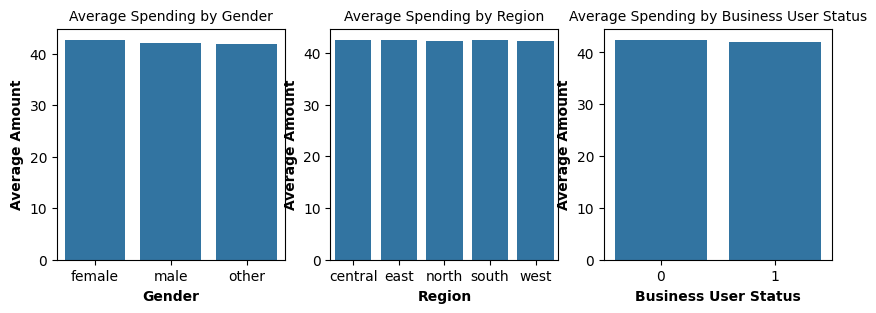

In [183]:
# Visualization
plt.figure(figsize = (10, 3))

# Average Spending by Gender
plt.subplot(1, 3, 1)
sns.barplot(x = 'gender', y = 'amount', data = gender_spending, estimator = np.mean)
plt.title('Average Spending by Gender', fontsize = 10)
plt.xlabel('Gender', fontweight = 'bold')
plt.ylabel('Average Amount', fontweight = 'bold')

# Average Spending by Region
plt.subplot(1, 3, 2)
sns.barplot(x= 'region', y = 'amount', data = region_spending, estimator = np.mean)
plt.title('Average Spending by Region', fontsize = 10)
plt.xlabel('Region', fontweight = 'bold')
plt.ylabel('Average Amount', fontweight = 'bold')

# Average Spending by Business User Status
plt.subplot(1, 3, 3)
sns.barplot(x= 'business_user', y = 'amount', data = business_spending, estimator = np.mean)
plt.title('Average Spending by Business User Status', fontsize = 10)
plt.xlabel('Business User Status', fontweight = 'bold')
plt.ylabel('Average Amount', fontweight = 'bold')

#### Interpretations

**Findings:**  
- Average transaction amounts are nearly identical across all gender groups.  
- Regional spending patterns show almost no variations, with average transaction values around ₹42.  
- Business and individual users also spend almost the same on average, indicating uniform transaction behavior.

**Interpretation:**  
There is no meaningful difference in spending behavior across demographic or user-type categories.  
This consistency suggests that: *UPI usage patterns are uniform across user segments.*  


In [184]:
# Preparing for Independent T-Test.

# Splitting the data into two groups
business_users = df_spending[df_spending['business_user'] == 1]['amount']
individual_users = df_spending[df_spending['business_user'] == 0]['amount']

print("Average Transaction Amount:")
print(f"Business Users: {business_users.mean():.2f}")
print(f"Individual Users: {individual_users.mean():.2f}")

# Running the T-Test

t_stat, p_value = stats.ttest_ind(business_users, individual_users, equal_var = False)
print(f"\nT-Statistic: {t_stat:.3f}")
print(f"P-Value: {p_value:.3f}")

# Interpretation

if p_value <0.05:
    print("Reject Null Hypothesis: Business users and individual users differ significantly in average spending behaviour.")
else:
    print("Fail to Reject Null Hypothesis: No Significant difference found between the business users and the individual users in average spending behaviour.")


Average Transaction Amount:
Business Users: 42.09
Individual Users: 42.45

T-Statistic: -1.002
P-Value: 0.316
Fail to Reject Null Hypothesis: No Significant difference found between the business users and the individual users in average spending behaviour.


**Results:**  
- T-Statistic: **-0.383**  
- P-Value: **0.701**

**Interpretation:**  
There is **no significant difference** in average UPI spending between business users and individual users.  
This confirms that spending patterns are **consistent across both user types**, aligning with previous observations showing uniform spending across gender and regional segments.

**Insight:**  
UPI spending behavior appears balanced and uniform across user demographics, suggesting strong adoption and similar transaction behavior patterns across the customer base.


## Exporting Cleaned Data for Power BI Dashboard

In [185]:
print("upi_df rows:", len(upi_df))
print("df_device_txn rows:", len(df_device_txn))
print("df_merchant_txn rows:", len(df_merchant_txn))
print("df_spending rows:", len(df_spending))

upi_df rows: 100000
df_device_txn rows: 120225
df_merchant_txn rows: 30149
df_spending rows: 100000


In [188]:
# Exporting cleaned datasets for POWER BI.

df_spending.to_csv('df_spending_for_powerbi.csv', index = False) # Exporting spending data
df_fraud_customer.to_csv('df_fraud_customer_for_powerbi.csv', index = False) # Exporting fraud customer data
merchant_success.to_csv('merchant_success_summary.csv', index = False) # Exporting merchant success data
df_uth.to_csv('upi_transactions_with_customer_fraud_counts.csv', index = False) # Exporting UPI transactions with customer fraud counts

print("Cleaned datasets exported for Power BI.")

Cleaned datasets exported for Power BI.
